!!!Notebook run on Kaggle GPU(50min)

Imports and Downloads input data

In [1]:
#imports
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
#look for files/directories in competition
print(os.listdir("../input/airbus-ship-detection"))

['train_v2', 'test_v2', 'train_ship_segmentations_v2.csv', 'sample_submission_v2.csv']


In [3]:
#read train data(file which describe pixels with ships)
train = pd.read_csv("../input/airbus-ship-detection/train_ship_segmentations_v2.csv")

Exploratore and preprocessed the data

In [4]:
#info for null/not null values in file
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
ImageId          231723 non-null object
EncodedPixels    81723 non-null object
dtypes: object(2)
memory usage: 3.5+ MB


In [5]:
#look on data
train.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

There is one broken image. It must be delated

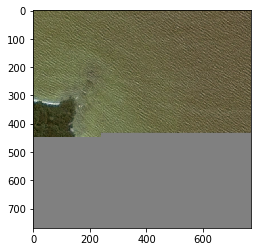

In [6]:
#plot broken image
plt.imshow(cv2.imread('../input/airbus-ship-detection/train_v2/6384c3e78.jpg'))

In [7]:
#and remove the,
train = train[train['ImageId'] != '6384c3e78.jpg']

In [8]:
#one object was deleted
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231722 entries, 0 to 231722
Data columns (total 2 columns):
ImageId          231722 non-null object
EncodedPixels    81723 non-null object
dtypes: object(2)
memory usage: 5.3+ MB


Images without ships more than at leastone ship. So need to normalize the data 

Images with ships: 42556


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd240f28c18>]],
      dtype=object)

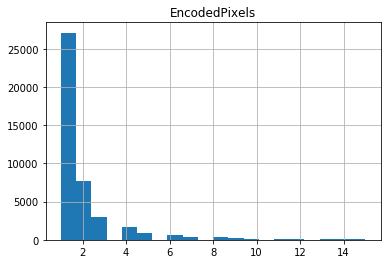

In [9]:
#plot distribution how many ships on one image if ships exists
print('Images with ships:', len(train[~train.EncodedPixels.isna()].ImageId.unique()))
train[~train.EncodedPixels.isna()].groupby(['ImageId']).count().hist(bins=20)

Images without ships: 149999


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd23fea6e80>]],
      dtype=object)

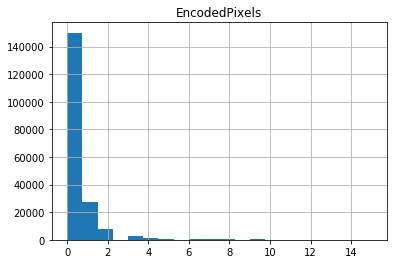

In [10]:
#same but for all images
print('Images without ships:', len(train[train.EncodedPixels.isna()]))
train.groupby(['ImageId']).count().hist(bins=20)

Left 80 000 images. About a half of them without ships

In [11]:
#count number to delete images without ships, 80 000 images will left
del_to =  - 80000 + len(train.ImageId.unique())
del_to

112555

In [12]:
deleted = train[train.EncodedPixels.isna()][:del_to].ImageId

In [13]:
train = train[~train.ImageId.isin(deleted)]

In [14]:
deleted.iloc[0:0]

Series([], Name: ImageId, dtype: object)

Images without ships: 37444
All images num: 80000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd23fddc7b8>]],
      dtype=object)

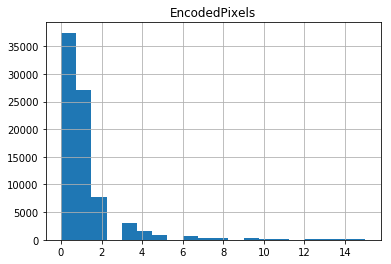

In [15]:
#distribution again
print('Images without ships:', len(train[train.EncodedPixels.isna()]))
print('All images num:', len(train.ImageId.unique()))
train.groupby(['ImageId']).count().hist(bins=20)

Function for visualizing, creation and processed data

In [16]:
#return image mask from list of encoded ships 
def mask_from_list(ships):
    if ships.isna().all(): return np.zeros((768,768), dtype=np.uint8)
    mask = np.zeros(768*768, dtype=np.uint8)
    for ship in ships:
        ship = list(map(int, ship.split()))
        for pair in range(len(ship)//2):
            start = ship[pair*2]
            end = start + ship[pair*2+1]
            mask[start:end] = 255
    return np.reshape(mask, (768,768)).transpose()

In [17]:
#return mask for list of image names
def masks_for_all(image_filenames):
    #l = len(image_filenames)
    masks= np.array([mask_from_list(train[train['ImageId']==image_filenames[0]].EncodedPixels)/255.0])
    images = np.array([cv2.imread('../input/airbus-ship-detection/train_v2/'+image_filenames[0])/255.0])
    #p = list(range(0,100,10))
    for i, filename in enumerate(image_filenames[1:]):
        #pr = int(i*100/l)
        #if pr in p:
        #    print(pr,"%")
        #    p.pop(0)
        mask = mask_from_list(train[train['ImageId']==filename].EncodedPixels)
        masks = np.append(masks,[mask/255.0], axis=0)
        images = np.append(images,[cv2.imread('../input/airbus-ship-detection/train_v2/'+filename)/255.0],axis=0)
    return images, masks

In [18]:
#return mask for one image name
def mask_for_one(filename):
    img, mask = masks_for_all([filename])
    return img[0], mask[0]

In [19]:
#function for plotting original image + true mask + predicted mask
def show_img_mask(img, mask, pred = False, pred_mask=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 5))
    ax1.imshow(img)
    ax1.set_title('Image')
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Masks')
    if not pred:
        ax3.imshow(cv2.multiply(img, cv2.merge([mask, mask, mask])))
        ax3.set_title('Masks in colors')
    else:
        ax3.imshow(pred_mask, cmap='gray')
        ax3.set_title('Prediction mask')
    plt.show()

In [20]:
#function for augmentation(not use)
def four_in_one(img1, img2, img3, img4):
    new_img = np.zeros_like(img1, dtype=np.float32)
    new_img[:384, :384] = img1[:384, :384]
    new_img[384:, :384] = cv2.resize(img2[384:, :384], (768, 768))[384:, :384]
    new_img[:384, 384:] = cv2.resize(img3, (384, 384))
    pts1 = np.float32([[0,0],[767,0],[0,767],[767,767]])
    pts2 = np.float32([[767,767],[0,767],[767,0],[0,0]])
    M = cv2.estimateAffine2D(pts1,pts2)[0]
    new_img[384:, 384:] = cv2.warpAffine(img4,M,(768,768))[384:, 384:]
    return new_img

In [21]:
#function for augmentation(not use)
def add_data(lenght):
    len_per_class = lenght//4
    new_images = np.array([four_in_one(images[0], images[len_per_class], images[len_per_class*2], images[len_per_class*3])])
    new_masks = np.array([four_in_one(masks[0], masks[len_per_class], masks[len_per_class*2], masks[len_per_class*3])])
    for i in range(1,len_per_class):
        img = four_in_one(images[i], images[len_per_class+i], images[len_per_class*2 + i], images[len_per_class*3 + 1])
        mask = four_in_one(masks[i], masks[len_per_class+i], masks[len_per_class*2 + i], masks[len_per_class*3 + 1])
        new_images = np.append(new_images,[img], axis=0)
        new_masks = np.append(new_masks,[mask], axis=0)
    yield new_images, new_masks

In [22]:
#batch generator in order to using less memory
def mygenerator(name_list, batch_size=2, augment=False):
    k = 0
    while True:
        if k+batch_size >= len(name_list):
            k = 0
        imgs = []
        masks = []
        for name in name_list[k:k+batch_size]:
                tmp_img = cv2.imread('../input/airbus-ship-detection/train_v2/' + name)
                imgs.append(tmp_img)
                mask_list = train['EncodedPixels'][train['ImageId'] == name]
                one_mask = np.zeros((768, 768, 1))
                one_mask[:,:,0] += mask_from_list(mask_list)
                masks.append(one_mask)
        imgs = np.stack(imgs, axis=0)
        masks = np.stack(masks, axis=0)
        imgs = imgs / 255.0
        masks = masks / 255.0
        k += batch_size
        yield imgs, masks

For training model will be use 90% of normalized data. Split data on same percentage of non-ship and with-ship images

In [23]:
#split on train and validation sets(first all images without ships)
split_to = int(len(train[train.EncodedPixels.isna()].ImageId.unique())*0.9)
names_train_na, names_valid_na = train[train.EncodedPixels.isna()].ImageId.to_list()[:split_to], train[train.EncodedPixels.isna()].ImageId.to_list()[split_to:]
split_to = int(len(train[~train.EncodedPixels.isna()].ImageId.unique())*0.9)
names_train_nna, names_valid_nna = list(train[~train.EncodedPixels.isna()].ImageId.unique())[:split_to], list(train[~train.EncodedPixels.isna()].ImageId.unique())[split_to:]
names_train = names_train_na + names_train_nna
names_valid = names_valid_na + names_valid_nna

Create data with batch of 2

In [24]:
#create train/validation data
BATCH_SIZE = 2
train_data = mygenerator(names_train, batch_size=BATCH_SIZE, augment=False)
valid_data = mygenerator(names_valid, batch_size=BATCH_SIZE, augment=False)

Show few images with masks

In [25]:
names_for_visialusation = [names_train_na[0]]+names_train_nna[:2] 
images, masks = masks_for_all(names_for_visialusation)

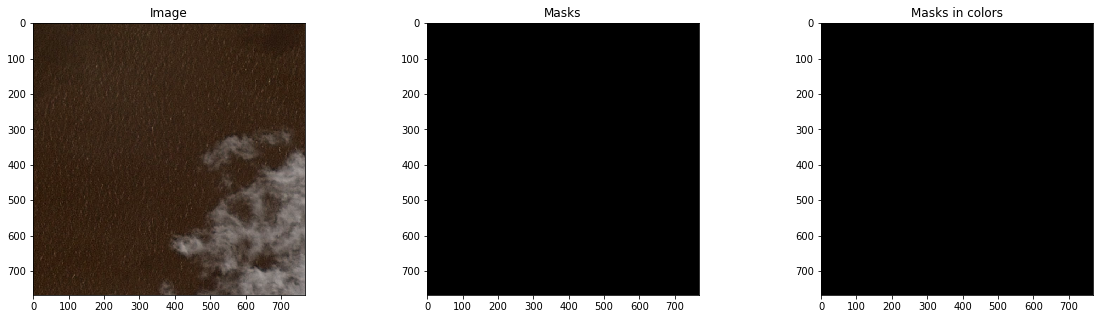

In [26]:
show_img_mask(images[0], masks[0])

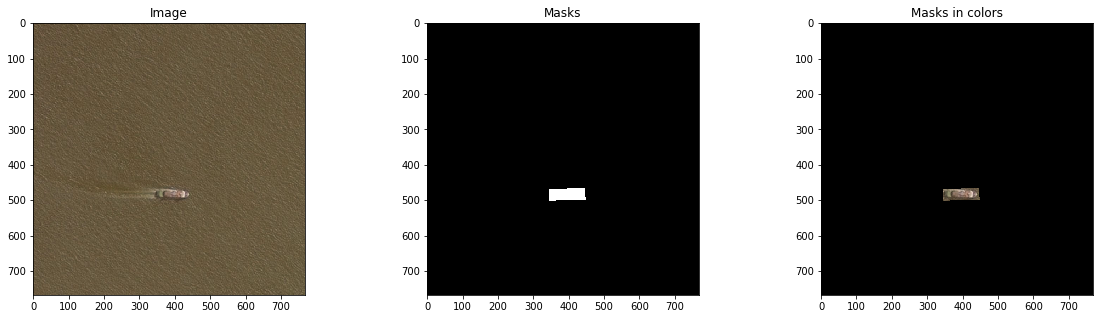

In [27]:
show_img_mask(images[1], masks[1])

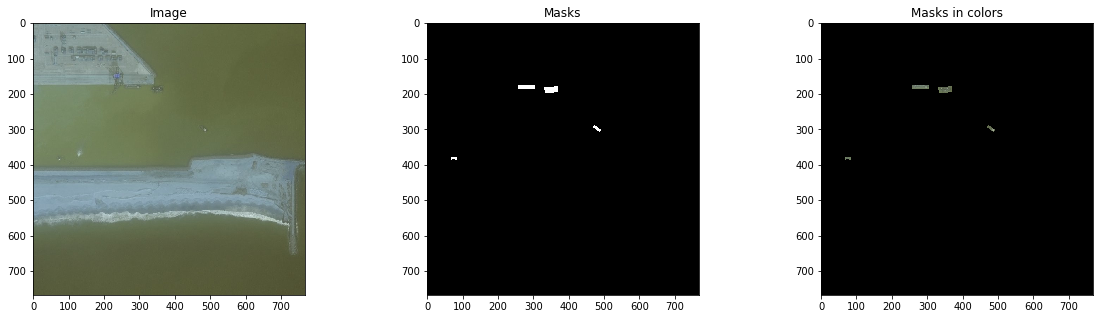

In [28]:
show_img_mask(images[2], masks[2])

UNet model will have 6 layers for downscaling image and 6 for upscaling. With relu activation, normalization and pooling layers. Default karnel sixe of 3 and dropaut 0.3. Number of filters first increas twise each time then decrease.

In [29]:
#import keras 
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam

Using TensorFlow backend.


In [30]:
#return Unet model
def unet_model(images, n_filters=8, kernel_size=3, dropout=0.3):
    #first 2 concolution layers, number of filters increas twise with each 2 layers
    conv0 = Conv2D(filters=n_filters, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(images)
    #with normalization layers
    conv0 = BatchNormalization()(conv0)
    #and relu activation
    conv0 = Activation('relu')(conv0)
    conv0 = Conv2D(filters=n_filters, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(images)
    conv0 = BatchNormalization()(conv0)
    conv0 = Activation('relu')(conv0)
    #pooling layer
    pool0 = AveragePooling2D((6,6))(conv0)
    #and layer for decrease overfitting
    pool0 = Dropout(dropout)(pool0)
    
    conv1 = Conv2D(filters=n_filters*2, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(pool0)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(filters=n_filters*2, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = AveragePooling2D((4,4))(conv1)
    pool1 = Dropout(dropout)(pool1)

    conv2 = Conv2D(filters=n_filters*4, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(filters=n_filters*4, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((4,4))(conv2)
    pool2 = Dropout(dropout)(pool2)

    conv3 = Conv2D(filters=n_filters*8, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(filters=n_filters*8, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(dropout)(pool3)

    conv4 = Conv2D(filters=n_filters*16, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(filters=n_filters*16, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(dropout)(pool4)

    conv5 = Conv2D(filters=n_filters*32, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(filters=n_filters*32, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    
    #use upsampling layer instead one of concolutional 
    upcv6 = Conv2DTranspose(n_filters*16, (3,3), strides=(2,2), padding='same')(conv5)
    #and concatenate with privious results
    mrge6 = concatenate([conv4, upcv6], axis=3)
    mrge6 = Dropout(dropout)(mrge6)
    conv6 = Conv2D(filters=n_filters*16, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(mrge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(filters=n_filters*16, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    upcv7 = Conv2DTranspose(n_filters*8, (3,3), strides=(2,2), padding='same')(conv6)
    mrge7 = concatenate([conv3, upcv7], axis=3)
    mrge7 = Dropout(dropout)(mrge7)
    conv7 = Conv2D(filters=n_filters*8, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(mrge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(filters=n_filters*8, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    upcv8 = Conv2DTranspose(n_filters*4, (3,3), strides=(4,4), padding='same')(conv7)
    upcv8 = BatchNormalization()(upcv8)
    mrge8 = concatenate([conv2, upcv8], axis=3)
    mrge8 = Dropout(dropout)(mrge8)
    conv8 = Conv2D(filters=n_filters*4, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(mrge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(filters=n_filters*4, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    upcv9 = Conv2DTranspose(n_filters*2, (3,3), strides=(4,4), padding='same')(conv8)
    upcv9 = BatchNormalization()(upcv9)
    mrge9 = concatenate([conv1, upcv9], axis=3)
    mrge9 = Dropout(dropout)(mrge9)
    conv9 = Conv2D(filters=n_filters*2, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(mrge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(filters=n_filters*2, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    upcv10 = Conv2DTranspose(n_filters, (3,3), strides=(6,6), padding='same')(conv9)
    mrge10 = concatenate([upcv10, conv0], axis=3)
    mrge10 = Dropout(dropout)(mrge10)
    conv10 = Conv2D(filters=n_filters, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(mrge10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation('relu')(conv10)
    conv10 = Conv2D(filters=n_filters, kernel_size=(kernel_size,kernel_size), padding='same', kernel_initializer='he_normal')(conv10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation('relu')(conv10)
    
    #output layer
    outputs = Conv2D(1, (1,1), activation='sigmoid')(conv10)
    model = Model(inputs=images, outputs=outputs)
    return model

Specifie model with DICE metric, binary_crossentropy, early stopping, checkpoint. Model will train for 25 epoch with step 500 on train data. Firs was 40 epoch but model had overfiting. So number of epoch was redused 

In [31]:
#initialize model
inputs = Input(shape=(768,768,3))
model = unet_model(inputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 768, 768, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 768, 768, 8)  32          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 768, 768, 8)  0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [32]:
#function for DICE metric
from keras.backend import sum as Ksum, abs as Kabs, square as Ksquare
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = Ksum(Kabs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (Ksum(Ksquare(y_true),-1) + Ksum(Ksquare(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [33]:
#set parameters to model and start learning
from keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
model.compile(optimizer = Adam(), loss='binary_crossentropy', metrics=[dice_coef])
callbacks = [EarlyStopping(patience=10, verbose=1, mode='max'),
        ReduceLROnPlateau(monitor='val_dice_coef',mode='max', factor=0.1,patience=5,min_lr=0.00001, verbose=1),
        ModelCheckpoint('../output/model-ships.h5',monitor="val_dice_coef", mode='max', verbose=1, save_best_only=True, save_weights_only=True)]
history = model.fit_generator(train_data,steps_per_epoch=500, epochs=25, callbacks=callbacks)

Epoch 1/25
500/500 [==============================] - 83s 167ms/step - loss: 0.5201 - dice_coef: 0.8631
Epoch 2/25
  1/500 [..............................] - ETA: 1:13 - loss: 0.2246 - dice_coef: 0.9604

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,dice_coef
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_dice_coef` which is not available. Available metrics are: loss,dice_coef,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_dice_coef available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


500/500 [==============================] - 58s 116ms/step - loss: 0.1071 - dice_coef: 0.9878
Epoch 3/25
500/500 [==============================] - 58s 117ms/step - loss: 0.0288 - dice_coef: 0.9990
Epoch 4/25
500/500 [==============================] - 58s 117ms/step - loss: 0.0121 - dice_coef: 0.9998
Epoch 5/25
500/500 [==============================] - 58s 116ms/step - loss: 0.0062 - dice_coef: 1.0000
Epoch 6/25
500/500 [==============================] - 58s 116ms/step - loss: 0.0036 - dice_coef: 1.0000
Epoch 7/25
500/500 [==============================] - 58s 116ms/step - loss: 0.0022 - dice_coef: 1.0000
Epoch 8/25
500/500 [==============================] - 58s 115ms/step - loss: 0.0015 - dice_coef: 1.0000
Epoch 9/25
500/500 [==============================] - 57s 115ms/step - loss: 9.9576e-04 - dice_coef: 1.0000
Epoch 10/25
500/500 [==============================] - 57s 115ms/step - loss: 6.9164e-04 - dice_coef: 1.0000
Epoch 11/25
500/500 [==============================] - 57s 115ms/s

Plot history of loss and metric per epoch

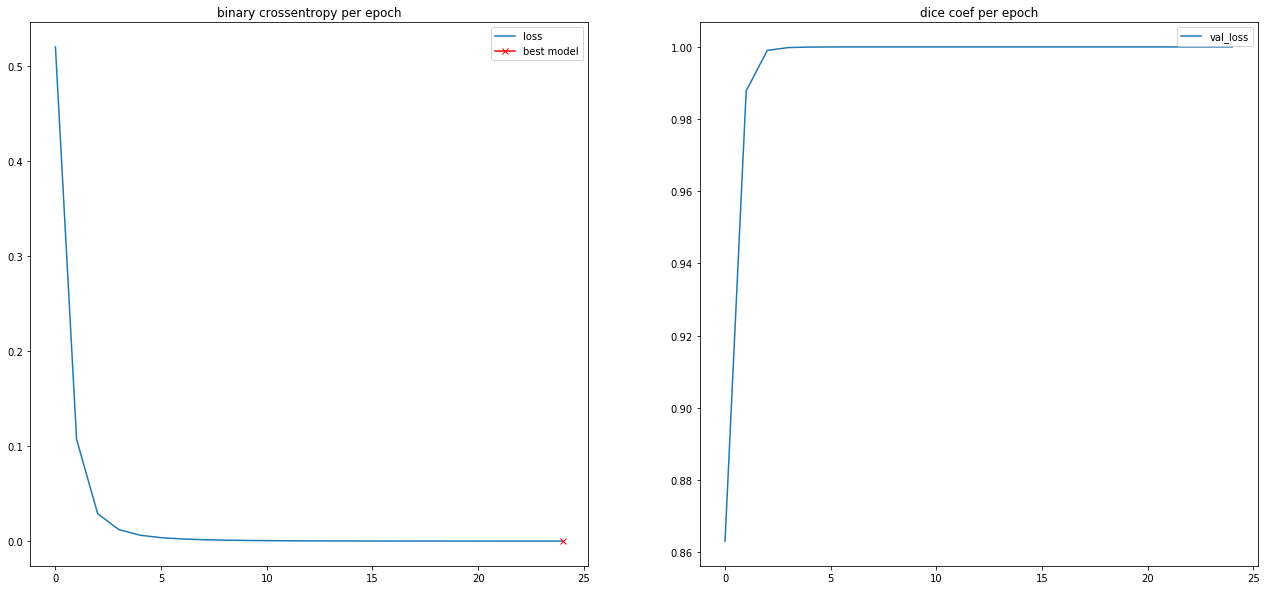

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
ax1.plot(history.history["loss"], label="loss")
ax1.plot( np.argmin(history.history["loss"]), np.min(history.history["loss"]), marker="x", color="r", label="best model")
ax1.set_title('binary crossentropy per epoch')
ax1.legend();
ax2.plot(history.history["dice_coef"], label="val_loss")
ax2.set_title('dice coef per epoch')
ax2.legend();
plt.show()

In [35]:
#load if there is checkpoint with best score 
try:
    model = load_model('model-ships.h5')
except:
    print('File not found')

File not found


Evaluate model on validation data

In [36]:
evaluation = model.evaluate_generator(valid_data, verbose=1,steps=500)

500/500 [==============================] - 43s 85ms/step


In [37]:
evaluation

[4.574390914058313e-06, 1.0]

Search for optimal threshold which will use for prediction on test data

In [38]:
#return score of prediction
def calc_score_one_image(mask_true, mask_pred):
    mask_true = mask_true.reshape(768,768)
    mask_pred = mask_pred.reshape(768,768)
    if mask_true.sum() == 0 and mask_pred.sum() == 0:
        score = 1
    elif mask_true.sum() == 0 and mask_pred.sum() != 0:
        score = 0
    elif mask_true.sum() != 0 and mask_pred.sum() == 0:
        score = 0
    else:
        score = dice_coef(mask_true, mask_pred)
    return score

In [39]:
#return score for botch of images
def calc_score_all_image(batch_mask_true, batch_mask_pred, threshold=0.5):
    num = batch_mask_true.shape[0]
    #tmp = batch_mask_pred > threshold
    batch_mask_pred = np.where(batch_mask_pred>threshold, 1, 0)
    scores = list()
    for i in range(num):
        score = calc_score_one_image(batch_mask_true[i], batch_mask_pred[i])
        scores.append(score)
    return np.mean(scores)

In [40]:
#import trackbar
from tqdm import tqdm

In [41]:
#go throught different threschold to choose the best one
scores_list = dict()
threshold_list = [i/100 for i in range(10,90,5)]
v_names = names_valid[:500]+names_valid[-500:]#
for threshold in threshold_list:
    scores = []
    print(threshold)
    for i in tqdm(range(len(v_names)//2)):
        temp_list = names_valid[i*2:(i+1)*2]
        val_img, val_mask = masks_for_all(temp_list)
        pred_mask = model.predict(val_img)
        score = calc_score_all_image(val_mask, pred_mask, threshold=threshold)
        scores.append(score)
    val = np.sum(scores)/(len(names_valid)//2 *2)
    scores_list[threshold] = val

  0%|          | 0/500 [00:00<?, ?it/s]

0.1


  0%|          | 1/500 [00:00<01:03,  7.90it/s]

0.15


  0%|          | 1/500 [00:00<01:00,  8.30it/s]

0.2


  0%|          | 1/500 [00:00<01:01,  8.06it/s]

0.25


  0%|          | 1/500 [00:00<01:02,  8.00it/s]

0.3


  0%|          | 1/500 [00:00<01:00,  8.20it/s]

0.35


  0%|          | 1/500 [00:00<00:59,  8.36it/s]

0.4


  0%|          | 1/500 [00:00<01:20,  6.20it/s]

0.45


  0%|          | 1/500 [00:00<00:59,  8.43it/s]

0.5


  0%|          | 1/500 [00:00<01:15,  6.62it/s]

0.55


  0%|          | 1/500 [00:00<01:02,  7.94it/s]

0.6


  0%|          | 1/500 [00:00<01:03,  7.91it/s]

0.65


  0%|          | 1/500 [00:00<01:04,  7.78it/s]

0.7


  0%|          | 1/500 [00:00<01:01,  8.18it/s]

0.75


  0%|          | 1/500 [00:00<01:00,  8.29it/s]

0.8


  0%|          | 1/500 [00:00<01:00,  8.22it/s]

0.85


100%|██████████| 500/500 [01:02<00:00,  7.98it/s]


In [42]:
scores_list

{0.1: 0.060625,
 0.15: 0.06075,
 0.2: 0.0609375,
 0.25: 0.0614375,
 0.3: 0.0624375,
 0.35: 0.0625,
 0.4: 0.0625,
 0.45: 0.0625,
 0.5: 0.0625,
 0.55: 0.0625,
 0.6: 0.0625,
 0.65: 0.0625,
 0.7: 0.0625,
 0.75: 0.0625,
 0.8: 0.0625,
 0.85: 0.0625}

In [43]:
#choose best threshold
threshold = max(scores_list, key=scores_list.get)
threshold

0.35

Some visualisation of prediction on validation images

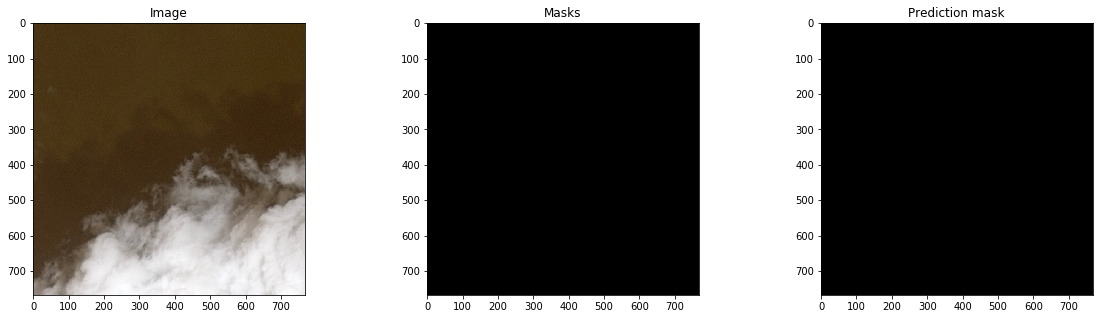

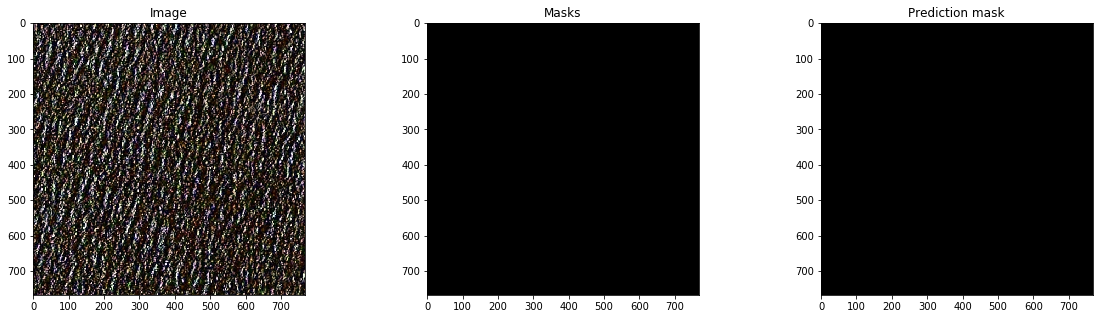

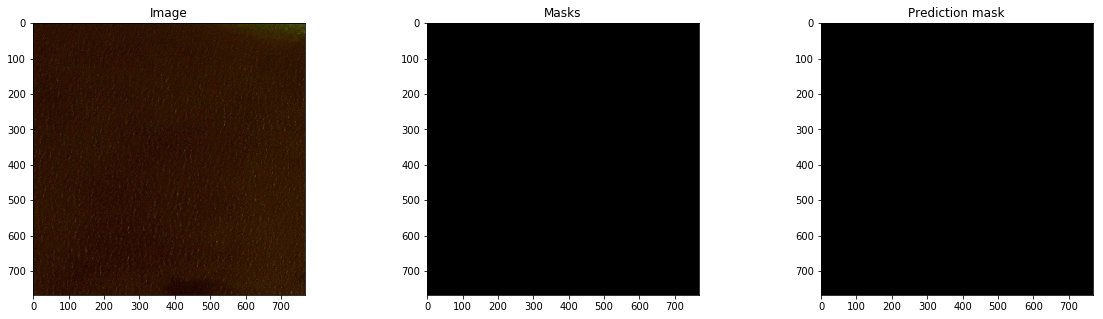

In [44]:
visualize_image_list = names_valid[:3]
for i in visualize_image_list:
    img, true_mask = masks_for_all([i])
    pred_mask = model.predict(img)
    pred_mask = np.where(pred_mask>threshold, 1, 0) 
    pred_mask = pred_mask.reshape(768,768)
    show_img_mask(img[0], true_mask[0], True, pred_mask)

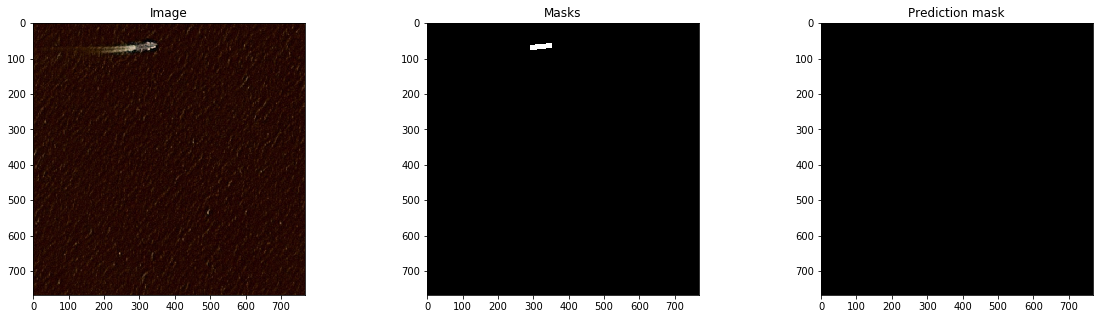

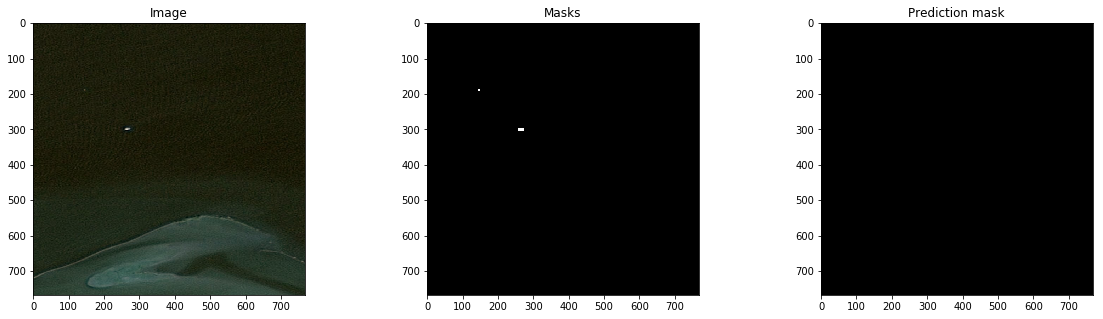

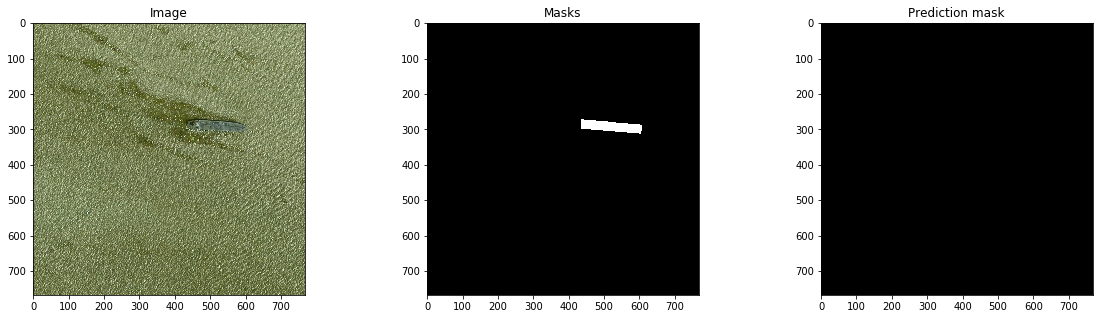

In [45]:
visualize_image_list = names_valid[-3:]
for i in visualize_image_list:
    img, true_mask = masks_for_all([i])
    pred_mask = model.predict(img)
    pred_mask = np.where(pred_mask>threshold, 1, 0) 
    pred_mask = pred_mask.reshape(768,768)
    show_img_mask(img[0], true_mask[0], True, pred_mask)

Same but threshold = 0.5.

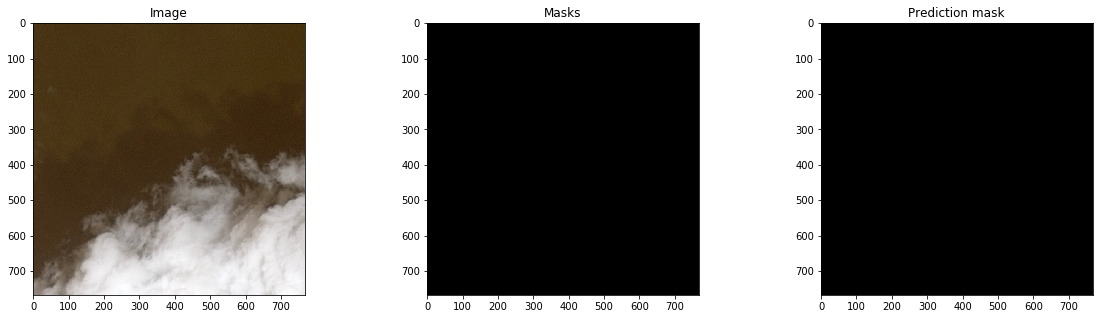

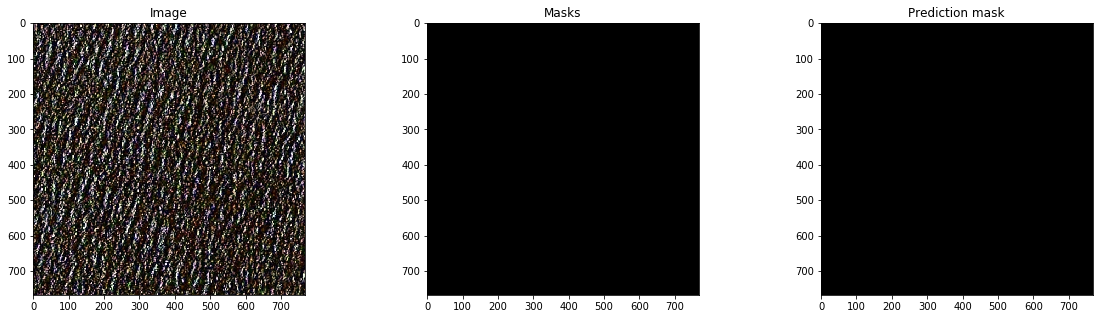

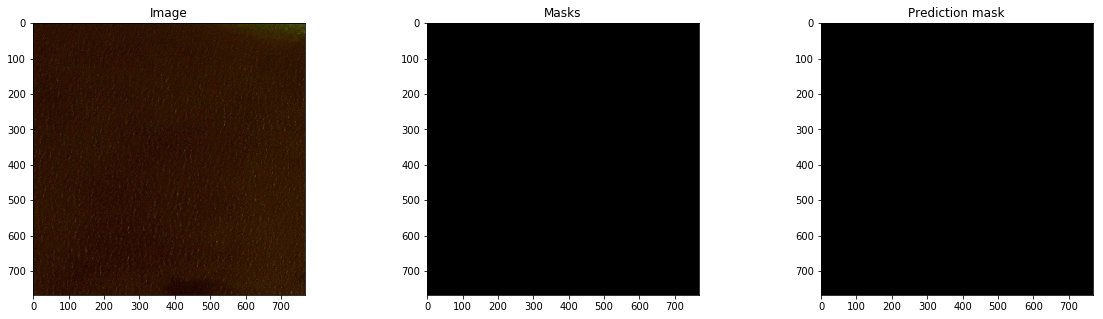

In [46]:
visualize_image_list = names_valid[:3]
for i in visualize_image_list:
    img, true_mask = masks_for_all([i])
    pred_mask = model.predict(img)
    pred_mask = np.where(pred_mask>0.5, 1, 0) 
    pred_mask = pred_mask.reshape(768,768)
    show_img_mask(img[0], true_mask[0], True, pred_mask)

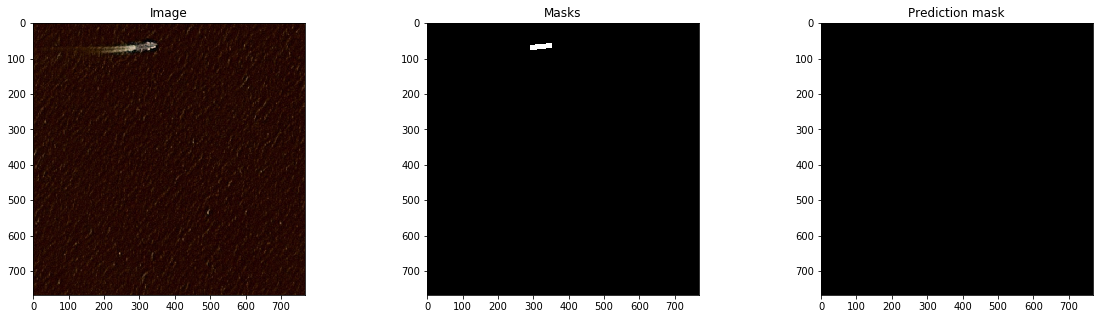

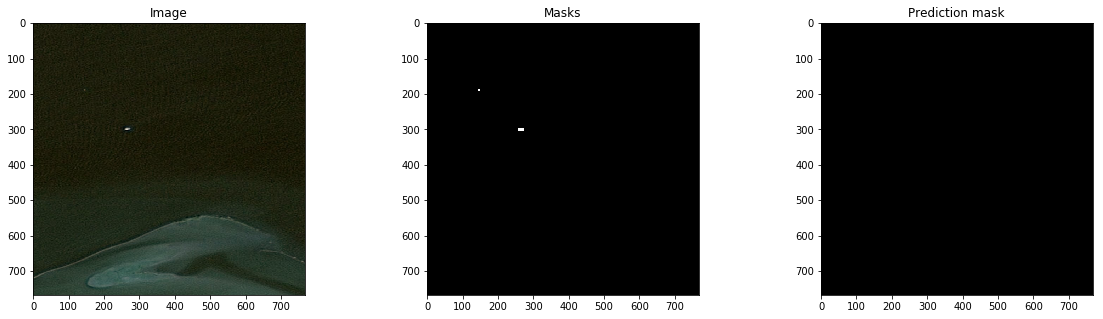

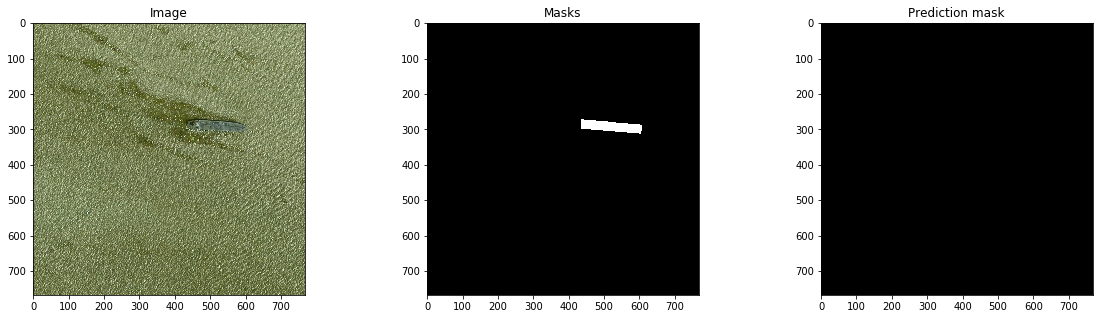

In [47]:
visualize_image_list = names_valid[-3:]
for i in visualize_image_list:
    img, true_mask = masks_for_all([i])
    pred_mask = model.predict(img)
    pred_mask = np.where(pred_mask>0.5, 1, 0) 
    pred_mask = pred_mask.reshape(768,768)
    show_img_mask(img[0], true_mask[0], True, pred_mask)

Save/Dowload model

In [48]:
#save model
#model.load_weights(weight_path)
model.save('model-ships.h5')

In [49]:
#download model
dependencies = {
     'dice_coef': dice_coef
}
#model = load_model('model-ships.h5', custom_objects=dependencies)

 Dowload test data and specifie function for converting prrediction masks to competition submission format

In [50]:
#import test image names
test = pd.read_csv("../input/airbus-ship-detection/sample_submission_v2.csv")

In [51]:
#functions to transfor result to apropriate format for submission
from skimage.morphology import label
def multi_rle_encode(img):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2)) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < 0.5:
        return '' ## no need to encode if it's all zeros
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

Show some result on test images and download it to file. Thisee time not all test images will use because of lack of memory on Kaggle Kernels. 

In [52]:
output_names = []
output_encodes = []

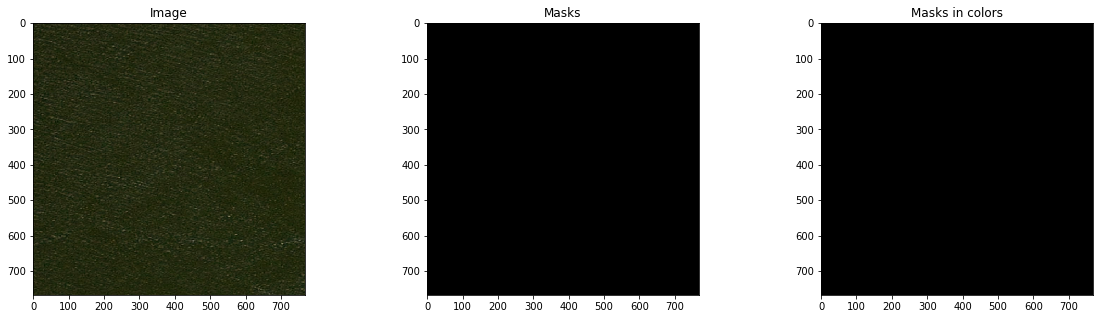

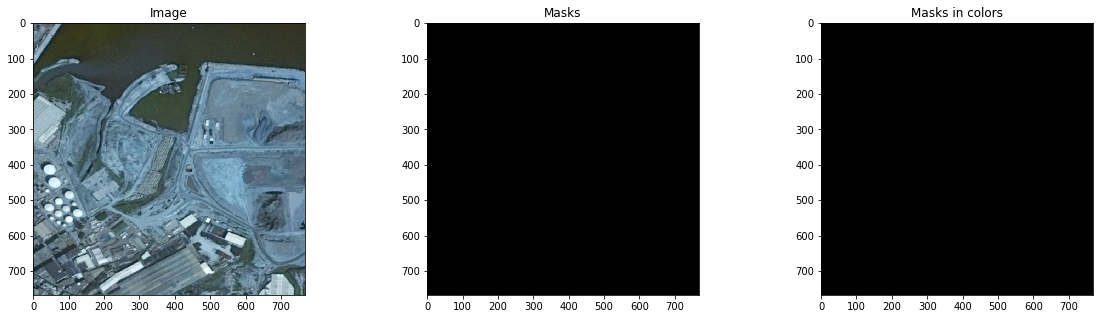

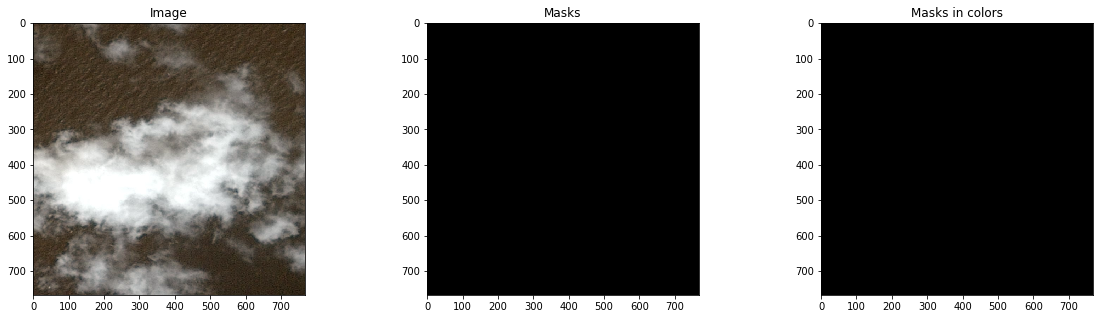

In [53]:
visualize_image_list = test.ImageId[[2, 3, 7]]
for i in visualize_image_list:
    img = cv2.imread('../input/airbus-ship-detection/test_v2/' + i)
    pred_mask = model.predict(np.array([img]))
    pred_mask = np.where(pred_mask>threshold, 1, 0) 
    pred_mask = pred_mask.reshape(768,768).astype(np.uint8)
    encodes = multi_rle_encode(pred_mask)
    output_encodes += encodes
    [output_names.append(i) for j in range(len(encodes))]
    show_img_mask(img, pred_mask)

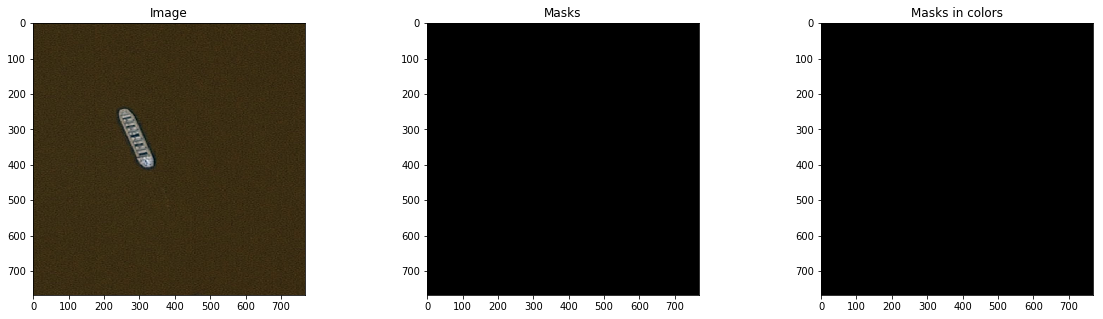

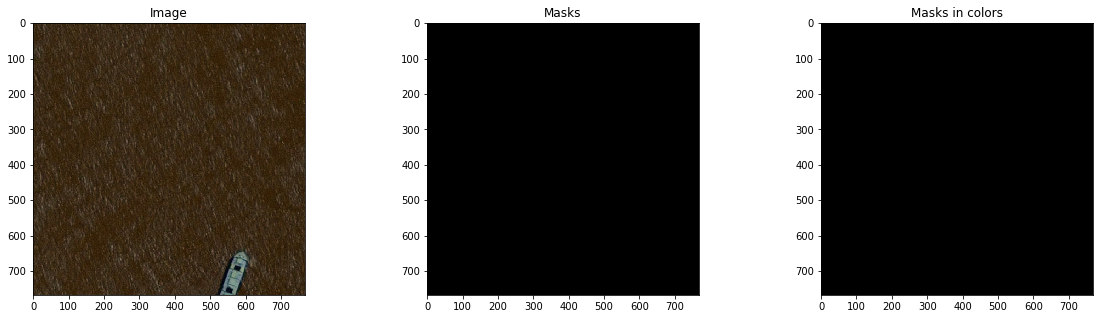

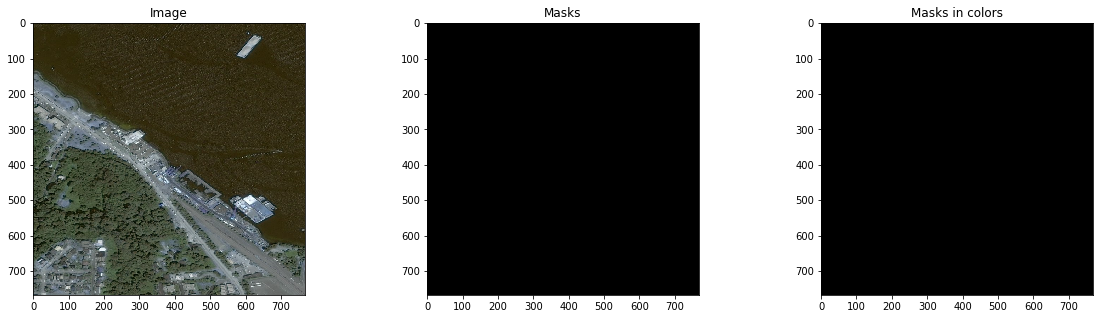

In [54]:
visualize_image_list = test.ImageId[[8, 10, 13]]
for i in visualize_image_list:
    img = cv2.imread('../input/airbus-ship-detection/test_v2/' + i)
    pred_mask = model.predict(np.array([img]))
    pred_mask = np.where(pred_mask>threshold, 1, 0) 
    pred_mask = pred_mask.reshape(768,768).astype(np.uint8)
    encodes = multi_rle_encode(pred_mask)
    output_encodes += encodes
    [output_names.append(i) for j in range(len(encodes))]
    show_img_mask(img, pred_mask)

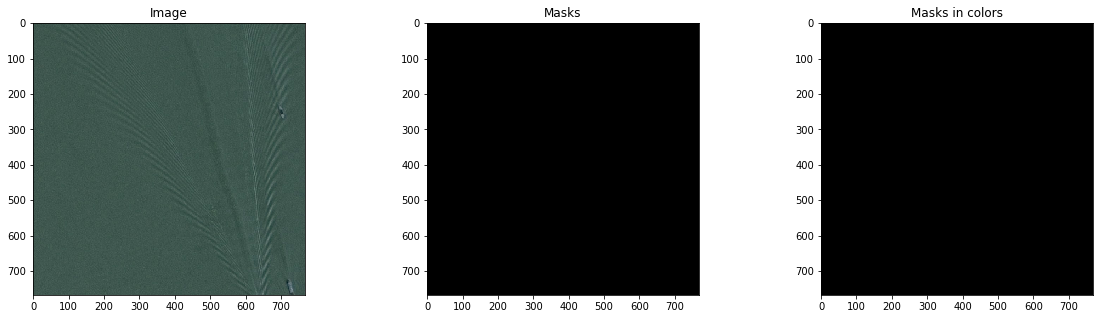

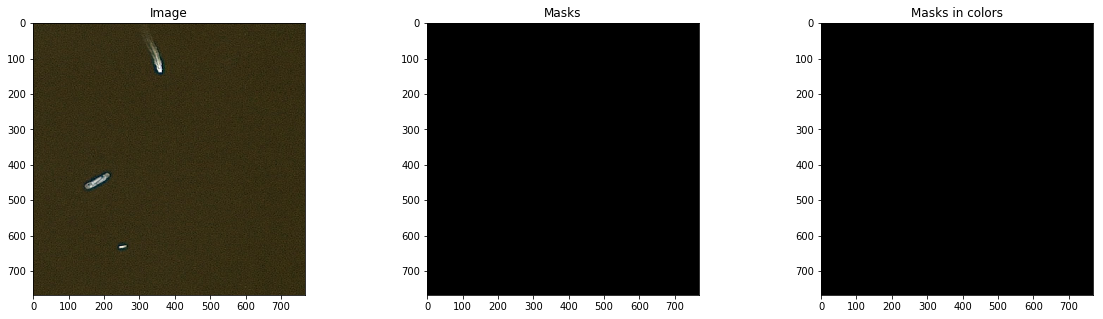

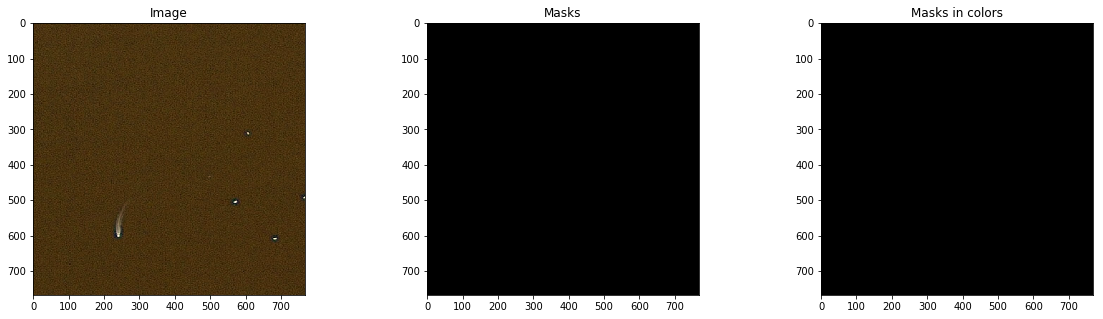

In [55]:
visualize_image_list = test.ImageId[[46, 47, 50]]
for i in visualize_image_list:
    img = cv2.imread('../input/airbus-ship-detection/test_v2/' + i)
    pred_mask = model.predict(np.array([img]))
    pred_mask = np.where(pred_mask>threshold, 1, 0) 
    pred_mask = pred_mask.reshape(768,768).astype(np.uint8)
    encodes = multi_rle_encode(pred_mask)
    output_encodes += encodes
    [output_names.append(i) for j in range(len(encodes))]
    show_img_mask(img, pred_mask)

Convert to DataFrame and save as .csv file

In [56]:
output = pd.DataFrame (zip(output_names, output_encodes), columns = ['ImageId','EncodedPixels'])

In [57]:
output.head()

Empty DataFrame
Columns: [ImageId, EncodedPixels]
Index: []

In [58]:
output.to_csv('submission.csv', index=False)

Save model and submissin files

In [ ]:
#save model file
#from IPython.display import FileLink
#FileLink(r'model-ships.h5')

In [ ]:
#sane submition file
#FileLink(r'submission.csv')

I can assume that the model overfited or decided to always return an empty mask for the best accuracy. <b>
I think this model not good and can not be used in production